<a href="https://colab.research.google.com/github/Deepthiezio/GamePrediction/blob/main/GamePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting VG hits (>1 million sales) with LR, RFC**

In this notebook I analyze VG sales, use LR / RFC models to predict whether a game will sell over 1 million units (a "hit" game), and identify which features are most correlated to VG hits.

Test accuracy: 86.59%

Notebook sections:

->Data exploration and analysis

->Prediction model

->Which 2016 games can still become hits?


#-> Data exploration and analysis




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

In [2]:
df = pd.read_csv('videogame.csv', encoding="utf-8")
dfa = df
dfa = dfa.copy()
df[71:79]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
71,Donkey Kong Country,SNES,1994.0,Platform,Nintendo,4.36,1.71,3.00,0.23,9.30,NaN,NaN,NaN,NaN,NaN,NaN
72,Minecraft,X360,2013.0,Misc,Microsoft Game Studios,5.70,2.65,0.02,0.81,9.18,NaN,NaN,NaN,NaN,NaN,NaN
73,Animal Crossing: New Leaf,3DS,2012.0,Simulation,Nintendo,2.03,2.36,4.39,0.39,9.16,88.0,70.0,8.7,626.0,Nintendo,E
74,Mario Party DS,DS,2007.0,Misc,Nintendo,4.40,1.85,1.98,0.68,8.91,72.0,27.0,7.8,85.0,Hudson Soft,E
75,The Elder Scrolls V: Skyrim,X360,2011.0,Role-Playing,Bethesda Softworks,5.05,2.79,0.10,0.85,8.79,96.0,89.0,8.4,3589.0,Bethesda Game Studios,M
76,Super Mario Kart,SNES,1992.0,Racing,Nintendo,3.54,1.24,3.81,0.18,8.76,NaN,NaN,NaN,NaN,NaN,NaN
77,FIFA 16,PS4,2015.0,Sports,Electronic Arts,1.12,6.12,0.06,1.28,8.57,82.0,42.0,4.3,896.0,EA Sports,E
78,Halo 2,XB,2004.0,Shooter,Microsoft Game Studios,6.82,1.53,0.05,0.08,8.49,95.0,91.0,8.2,1218.0,Bungie Software,M


->Load data: Reads data from a CSV file into a table (df) using Pandas.

->   Make a copy: Creates a backup copy of the table (dfa).

-> Show a slice: Displays a specific portion (rows 70-77) of the original table (df).


# **Top values in the dataset**

**By platform, developer, publisher and genre.**

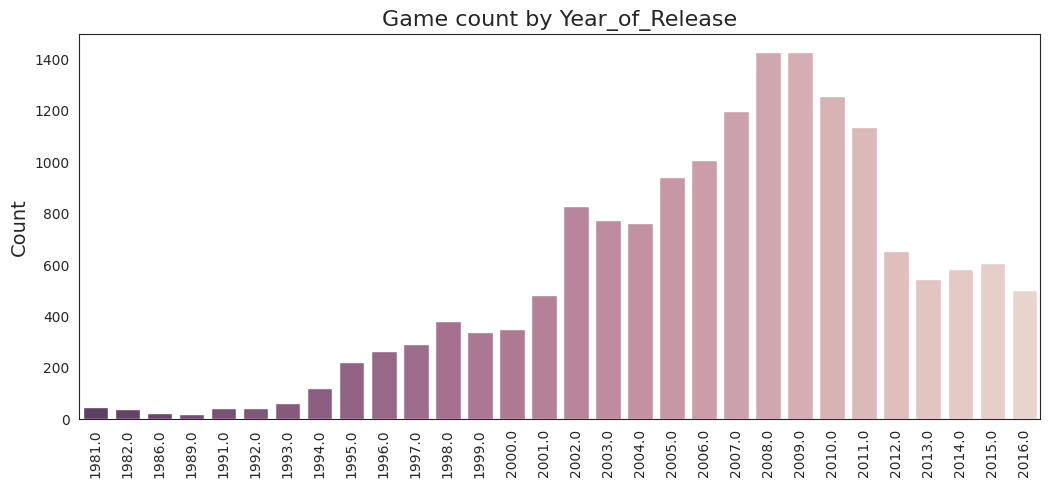

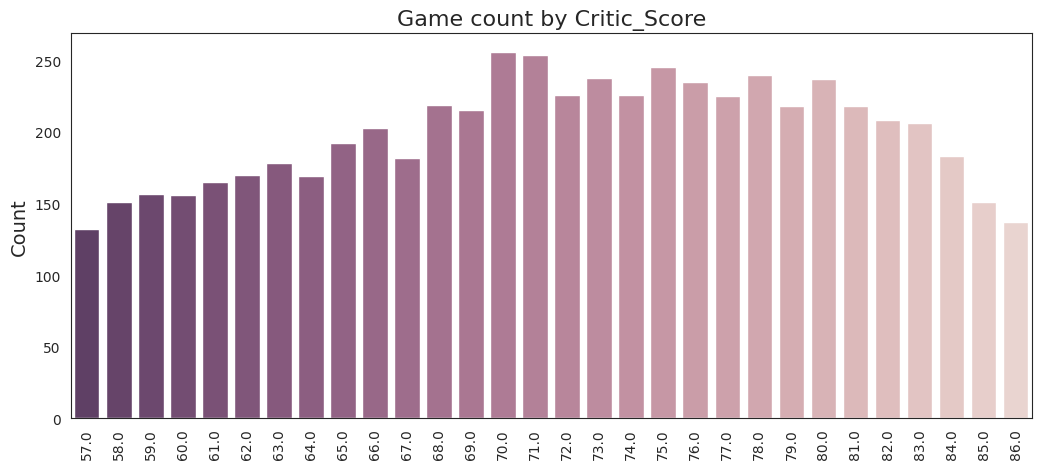

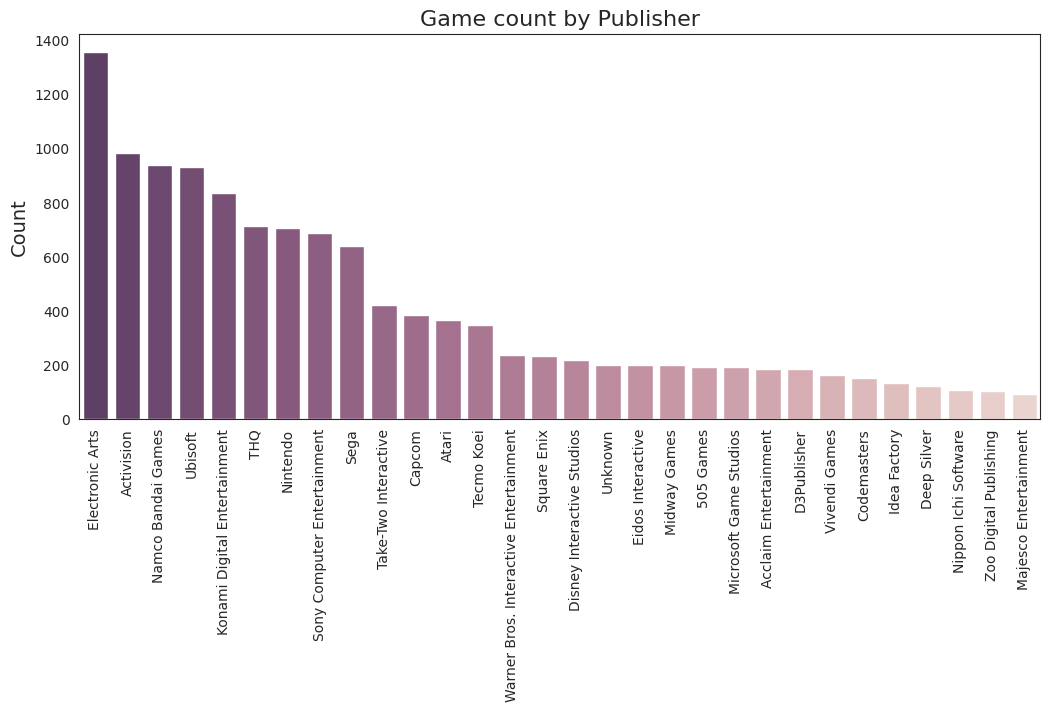

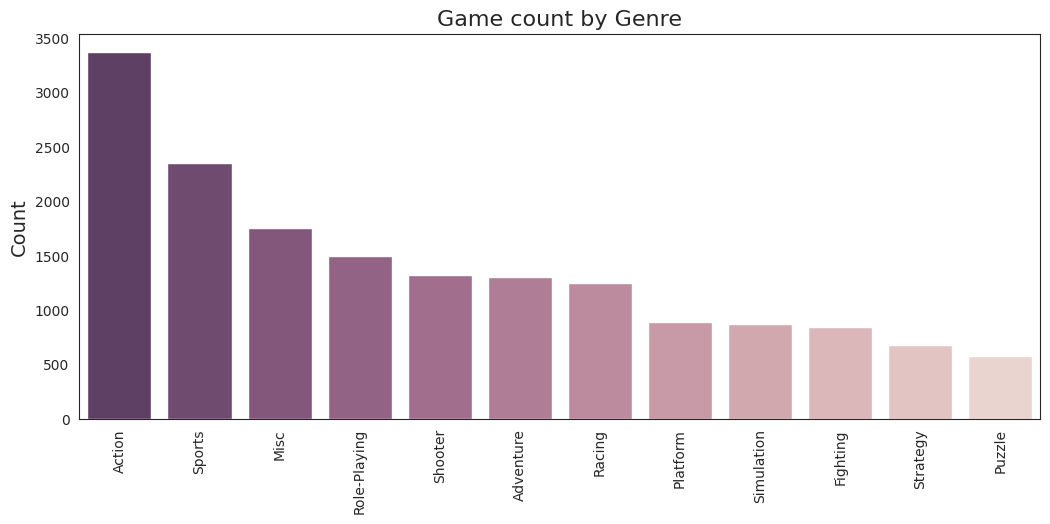

In [3]:
cols = ['Year_of_Release', 'Critic_Score', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)



    sns.barplot(x=col, y='Name', data=chart[:30], hue=col, palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True), dodge=False, legend=False).set_title(('Game count by '+col), fontsize=16)

    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')


1. Pick a column: The code starts by choosing a column to analyze (e.g., "Year_of_Release").

2. Count things: It goes through that column and counts how many times each value appears (e.g., how many games were released in 2008, 2009, etc.).

3. Pick the top 30: It selects the 30 most frequent values and their counts.

4. Create a bar chart: It uses these top 30 values to create a bar chart. The height of each bar represents how often that value appears.

5. Repeat for other columns: It does the same thing for the other columns ("Critic_Score", "Publisher", "Genre").


# Sales vs. critic scores
**By platform, developer, publisher, and genre.**

In [4]:
def score_group(score):
    if score >= 4000:
        return '4000-5000'
    elif score >= 3000:
        return '3000-3999'
    elif score >= 2000:
        return '2000-2999'
    elif score >= 1000:
        return '1000-1999'
    else:
        return '0-999'

In [5]:
dfh = df.dropna(subset=['User_Count']).reset_index(drop=True)
dfh['Score_Group'] = dfh['User_Count'].apply(lambda x: score_group(x)) # Changed val_group to score_group

In [6]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Platform':
        return 14.4
    elif x == 'Developer':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

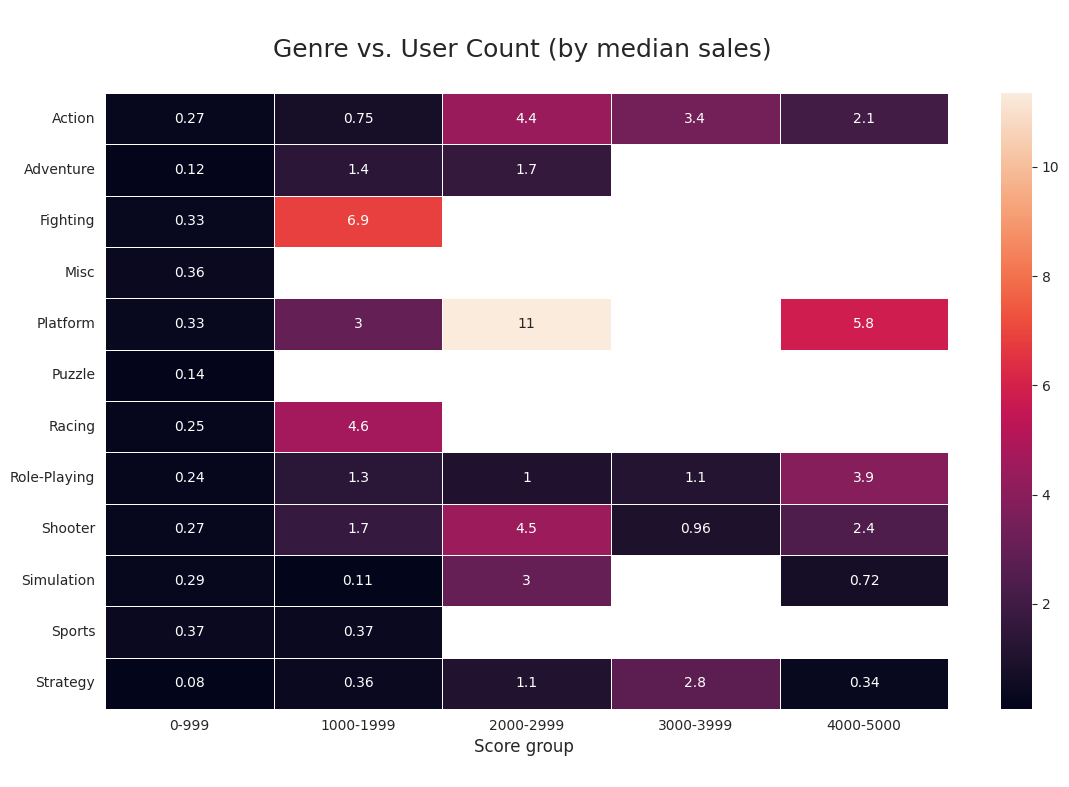

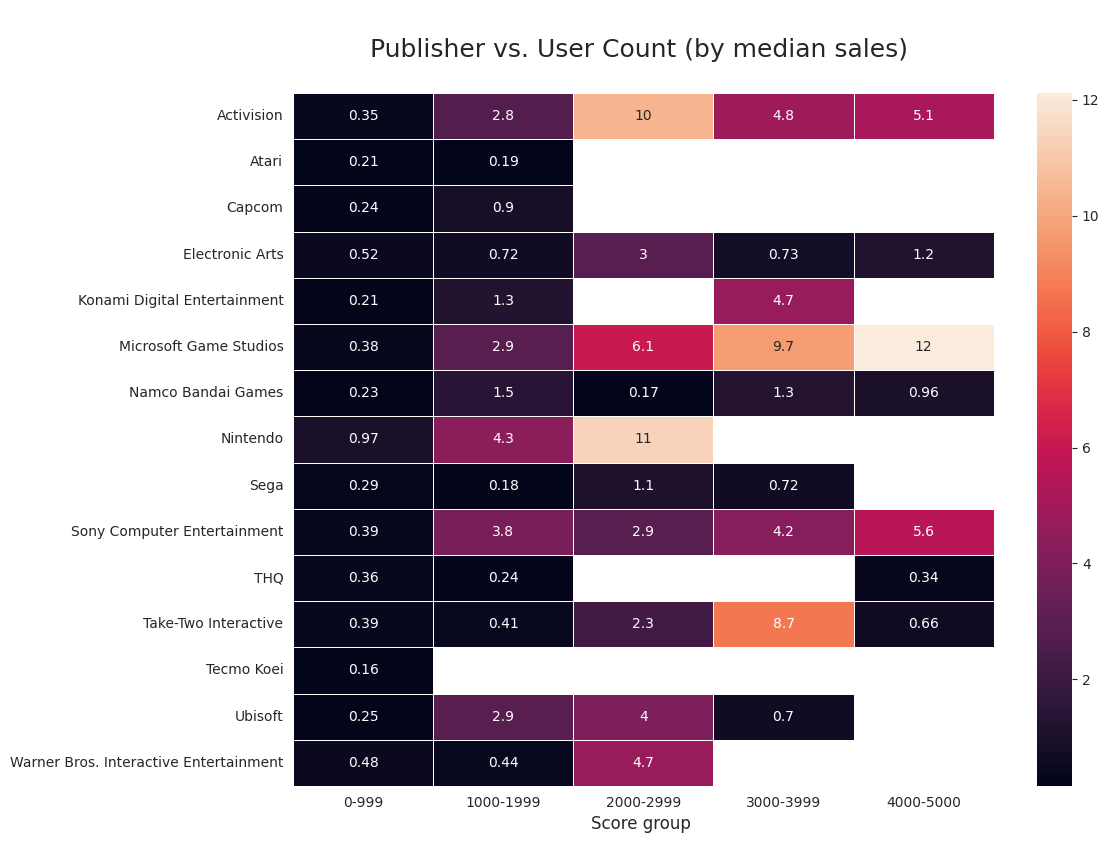

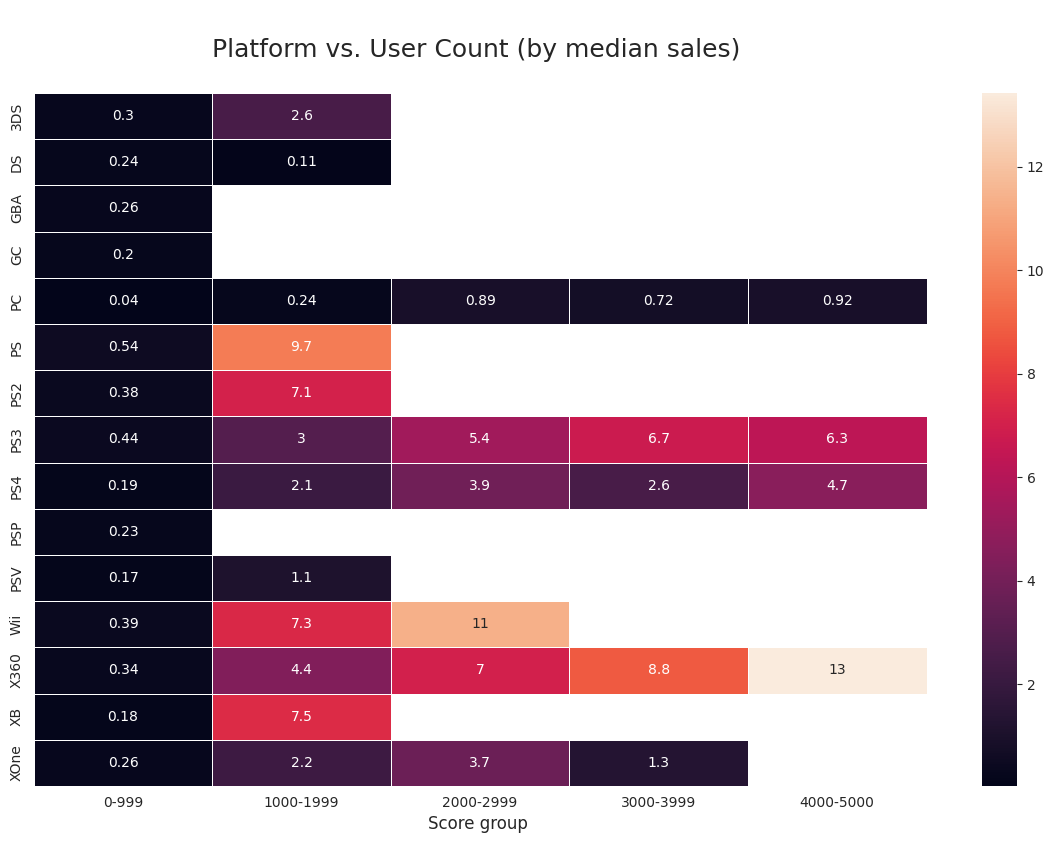

In [7]:
cols = ['Year_of_Release', 'Critic_Score', 'Genre', 'Publisher', 'Platform']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col,'Score_Group', 'Global_Sales']].groupby([col,'Score_Group']).median().reset_index().pivot(index=col, columns="Score_Group", values="Global_Sales")
    w = width(col)
    h = height(col)
    if w is None or h is None:
        print(f"Warning: Skipping plot for {col} due to invalid width or height.")
        continue
    plt.figure(figsize=(w, h))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. User Count (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []


->Grouping games based on how many users they have.

->Focusing on the most popular genres, publishers, platforms, etc.

->Creating colorful charts (heatmaps) that show how sales change for different combinations of these things.

# Dataset correlations
**Conversion of categorical columns into numeric codes**

In [8]:
cols = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [9]:
df1 = df[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

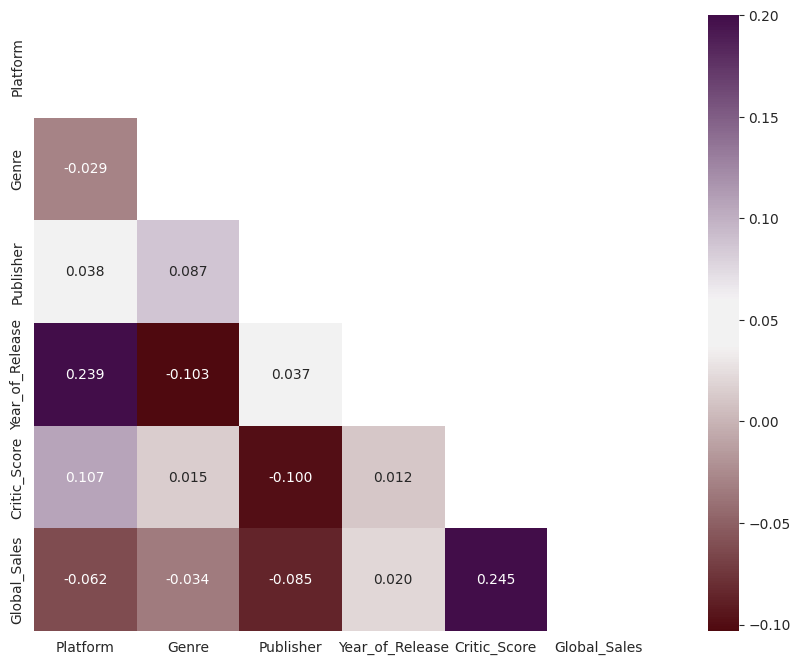

In [10]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

->Converting text categories (like "PlayStation") into numbers for easier analysis.

->Selecting the important features to look at (platform, genre, sales, etc.).

->Calculating how strongly those features are related to each other (correlation).

->Creating a colorful chart (heatmap) to visualize those relationships.

**The heatmap shows:**

**Strong positive correlations (close to 1):** These indicate that two features tend to increase or decrease together (e.g., higher critic scores might be associated with higher sales).

**Strong negative correlations (close to -1):** These indicate that one feature tends to increase when the other decreases (e.g., older release years might be associated with lower sales).

**Weak correlations (close to 0):** These indicate little or no relationship between two features.

**Strongest correlations are:**

***->Critic scores-to-global sales*: We'll take a closer look at this below.**

***->Year of release-to-platform*: This makes sense since new platforms come out periodically.**

[(0.0, 17.5)]

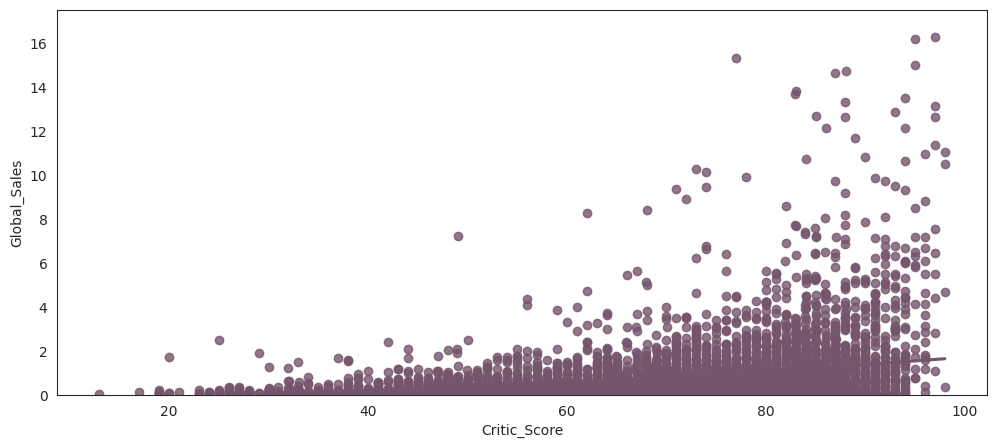

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

To get a better feel for the correlation we are going to use bins.

[(0.0, 4.0), (50.0, 95.0)]

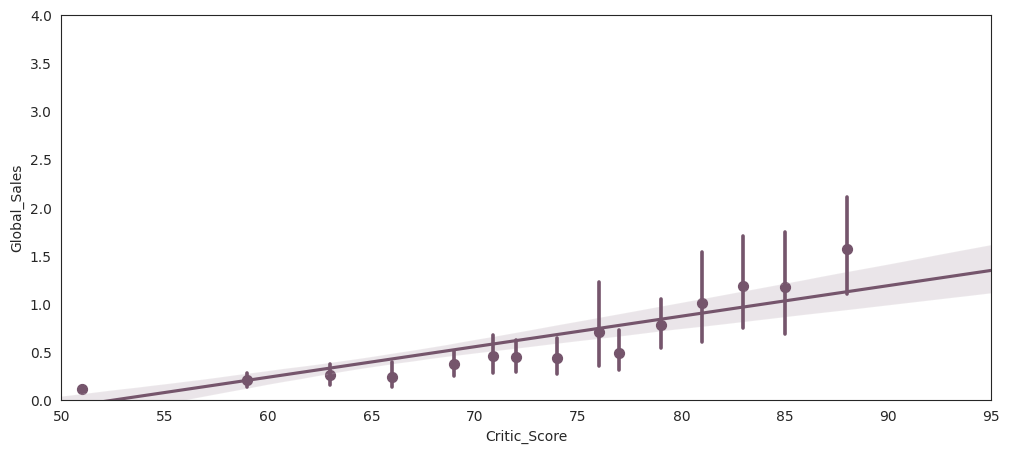

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

# **Defining hits as those with sales above 1 million units**
**This will be the target in our prediction model, where we'll predict if a game will be a hit or not.**

In [13]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [14]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0
df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

**The relationship between critic scores and VG hits using a 5% sample**

<Axes: xlabel='Critic_Score', ylabel='Hit'>

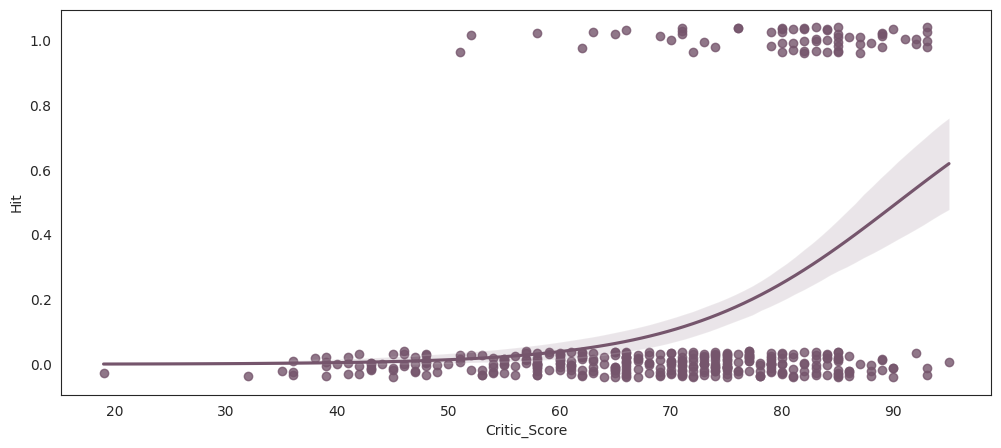

In [15]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

**This code helps you visualize that relationship.**

->It takes a small, random sample of your game data.

->It plots the critic scores on the x-axis and whether the game was a hit (yes/no) on the y-axis.

->It uses logistic regression to draw a curve that shows the probability of a game being a hit based on its critic score.

**The plot shows:**

 **The S-shaped curve:** This represents the logistic regression model, showing how the probability of a hit changes with the critic score.

**Data points:**These are the sampled games, with their critic scores and hit status.

**Shaded area:** This represents the confidence interval of the model, indicating the uncertainty in the estimated probabilities.

**hits are mostly found near high critic scores, while non-hits can vary in scores but don't have as strong of a presence in the high score ranges (as seen in the steepening regression curve near the 70's).
**


# **->Prediction model**
**For predicting VGs with unit sales of 1 million or higher (hits).**

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm

In [17]:
df2[71:79]

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
71,Wii,Action,Nintendo,2006.0,95.0,1
72,PS,Platform,Sony Computer Entertainment,1998.0,91.0,1
73,WiiU,Racing,Nintendo,2014.0,88.0,1
74,GC,Fighting,Nintendo,2001.0,92.0,1
75,PS2,Racing,Electronic Arts,2004.0,82.0,1
76,PS2,Shooter,Electronic Arts,2002.0,88.0,1
77,Wii,Misc,Ubisoft,2012.0,74.0,1
78,X360,Shooter,Microsoft Game Studios,2008.0,93.0,1


In [18]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)

# **Generating features**

In [19]:
df_copy[71:79]

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
71,2006.0,95.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
72,1998.0,91.0,1,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
73,2014.0,88.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
74,2001.0,92.0,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
75,2004.0,82.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76,2002.0,88.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77,2012.0,74.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
78,2008.0,93.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

**Predict if a new game will be a hit based on its features.**

**Separate features and target:** This code first separates the "Hit" column (what you want to predict) from the rest of the data (the features used for prediction).

 **Split into training and testing:** It then divides the data into two parts:

**Training data:** Used to train the model to learn patterns and relationships between features and hit status.

**Testing data:** Used to evaluate how well the trained model performs on unseen data, ensuring it can generalize to new games.

## **->Testing prediction accuracy with LR and RFC**

In [22]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.864946128789777


In [23]:
log_reg = LogisticRegression(max_iter=10000).fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                     == ytest) / len(ytest))


Validation accuracy:  0.8659483838636933


In [24]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3301
           1       0.74      0.35      0.47       690

    accuracy                           0.87      3991
   macro avg       0.81      0.66      0.70      3991
weighted avg       0.85      0.87      0.85      3991



Text(0.5, 1.0, 'Training Set Confusion Matrix')

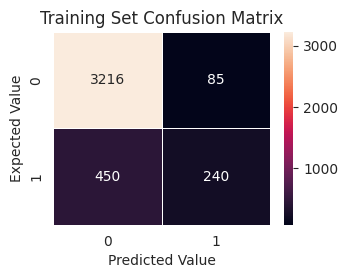

In [25]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
plt.title('Training Set Confusion Matrix') # Changed sns.plt.title to plt.title

# **Ranking feature performance**

In [26]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking (top 10):')

for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking (top 10):
1. feature 1 Critic_Score (0.326461)
2. feature 0 Year_of_Release (0.166946)
3. feature 216 Publisher_Nintendo (0.027233)
4. feature 19 Genre_Action (0.021519)
5. feature 99 Publisher_Electronic Arts (0.019508)
6. feature 27 Genre_Shooter (0.019204)
7. feature 42 Publisher_Activision (0.017003)
8. feature 29 Genre_Sports (0.016701)
9. feature 9 Platform_PS2 (0.014028)
10. feature 10 Platform_PS3 (0.014002)


# **Which 2016 games can still become hits?**

In [27]:
not_hit_copy = df_copy[df_copy['Hit'] == 0]

In [28]:
df4 = not_hit_copy
y = df4['Hit'].values
df4 = df4.drop(['Hit'],axis=1)
X = df4.values

In [29]:
pred = log_reg.predict_proba(X)

In [30]:
dfb = dfb[dfb['Global_Sales'] < 1]

In [32]:

dfb['Hit_Probability'] = pred[:,1]

In [31]:
dfb = dfb[dfb['Year_of_Release'] == 2016]
dfb.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
dfb = dfb[['Name', 'Platform', 'Hit_Probability']]

# **Top 10 games from 2016 with highest probability of becoming hits:**

In [33]:
dfb[:10].reset_index(drop=True)

,Name,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Global_Sales,Hit_Probability
0,NFL Fever 2002,XB,Sports,Microsoft Game Studios,2000.0,79.0,0.99,0.145341
1,Just Dance 2014,X360,Misc,Ubisoft,2013.0,79.0,0.99,0.331265
2,NCAA Football 12,X360,Sports,Electronic Arts,2011.0,82.0,0.99,0.359992
3,UFC Undisputed 3,X360,Action,THQ,2012.0,85.0,0.99,0.438449
4,Kirby: Mass Attack,DS,Platform,Nintendo,2011.0,83.0,0.99,0.725155
5,Haze,PS3,Shooter,Ubisoft,2008.0,55.0,0.99,0.079038
6,Oddworld: Abe's Exoddus,PS,Platform,GT Interactive,1998.0,88.0,0.99,0.428537
7,The Bouncer,PS2,Action,Sony Computer Entertainment,2000.0,66.0,0.99,0.155388
8,DiRT 2,PS3,Racing,Codemasters,2009.0,87.0,0.99,0.263458
9,Guitar Hero: Aerosmith,PS3,Misc,Activision,2008.0,70.0,0.99,0.315628


# **Top 10 games from 2016 with lowest probability of becoming hits:**

In [34]:
dfb[:-11:-1].reset_index(drop=True)

,Name,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Global_Sales,Hit_Probability
0,15 Days,PC,Adventure,DTP Entertainment,2009.0,63.0,0.01,0.004302
1,STORM: Frontline Nation,PC,Strategy,Unknown,2011.0,60.0,0.01,0.001043
2,Mega Brain Boost,DS,Puzzle,Majesco Entertainment,2008.0,48.0,0.01,0.002626
3,Bust-A-Move 3000,GC,Puzzle,Ubisoft,2003.0,53.0,0.01,0.007965
4,Breach,PC,Shooter,Destineer,2011.0,61.0,0.01,0.010053
5,Planet Monsters,GBA,Action,Titus,2001.0,67.0,0.01,0.019089
6,Metal Gear Solid V: Ground Zeroes,PC,Action,Konami Digital Entertainment,2014.0,80.0,0.01,0.062283
7,Mortal Kombat: Deadly Alliance,GBA,Fighting,Midway Games,2002.0,81.0,0.01,0.077152
8,Super Robot Taisen: Original Generation,GBA,Role-Playing,Banpresto,2002.0,72.0,0.01,0.026370
9,E.T. The Extra-Terrestrial,GBA,Action,NewKidCo,2001.0,46.0,0.01,0.003658
